# Assignment #1

## Overview of our assignment
* Given a face image dataset, namely CelebA, you need to perform classification on it, using MLP and multiple CNN architectures, and then report the results.
* We provide three models for classification, such as MLP, VGG, and ResNet-18, which can be used as the base architectures for your assignment.
* You should implement the following three regularization techniques: 1) Dropout, 2) L2 normalization, and 3) L1 normalization, based upon the provided three models, and then report the results. 
* Also, you should implement the following three optimization methods: 1) SGD with Momentum, 2) AdaGrad, and 3) Adam, and then report the obtained results as well.

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt
from PIL import Image

## Preparing the CelebA dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

Download link: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg

1) Download and unzip the file `./Img/img_align_celeba.zip`, which contains the images in jpeg format.

2) Download the `./Anno/list_attr_celeba.txt` file, which contains the class labels.

3) Download the `./Eval/list_eval_partition.txt` file, which contains  training/validation/test partitioning info.

Please make sure that, all your downloaded files (or unzipped folders) are located inside of the "./data" folder to run below codes.

For example,
* ./data/list_attr_celeba.txt
* ./data/list_eval_partition.txt
* ./data/img_align_celeba/{IMAGE_NAME}.jpg

In [7]:
df1 = pd.read_csv('./data/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male'])

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0
print(df1.head())
print(df1.shape)

            Male
000001.jpg     0
000002.jpg     0
000003.jpg     1
000004.jpg     0
000005.jpg     0
(202599, 1)


In [6]:
df2 = pd.read_csv('./data/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

print(df2.head())
print(df2.shape)

            Partition
Filename             
000001.jpg          0
000002.jpg          0
000003.jpg          0
000004.jpg          0
000005.jpg          0
(202599, 1)


In [51]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.head()
import os 
os.getcwd()

'/home/jungmin/2022-1 DL'

In [7]:
df3.to_csv('./data/celeba-gender-partitions.csv')
df4 = pd.read_csv('./data/celeba-gender-partitions.csv', index_col=0)
df4.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [8]:
df4.loc[df4['Partition'] == 0].to_csv('./data/celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('./data/celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('./data/celeba-gender-test.csv')

(218, 178, 3)


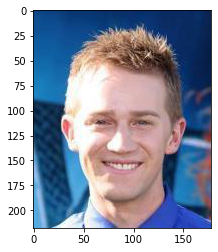

In [12]:
# Print sample image
img = Image.open('./data/img_align_celeba/img_align_celeba/000104.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

## Implementing the DataLoader for training, validation, and test

In [13]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [14]:
custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((32, 32)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

In [15]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

# custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
#                                        transforms.Resize((32, 32)),
#                                        #transforms.Grayscale(),                                       
#                                        #transforms.Lambda(lambda x: x/255.),
#                                        transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='./data/celeba-gender-train.csv',
                              img_dir='./data/img_align_celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='./data/celeba-gender-valid.csv',
                              img_dir='./data/img_align_celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='./data/celeba-gender-test.csv',
                             img_dir='./data/img_align_celeba/img_align_celeba/',
                             transform=custom_transform)

BATCH_SIZE=256


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=12)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=12)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=12)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(0)

cuda:0


In [17]:
# Testing dataloader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 256


## Implementing models

In [19]:
# Hyperparameters
random_seed = 42
learning_rate = 0.001
num_epochs = 10

# Architecture
num_features = 32*32
num_classes = 2

In [20]:
from models import mlp
from models import vgg
from models import resnet

## Define Base Model Function

In [90]:
def base_model_function(model, optimizer, num_epoch):
    start_time = time.time()
    
    num_epochs = num_epoch
    for epoch in range(num_epochs):
        # print(epoch)
        running_loss, val_running_loss = 0.0, 0.0
        running_corrects, val_running_corrects = 0.0, 0.0
        num_examples = 0

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            _, predicted_labels = torch.max(probas, 1)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ## loss 더해주기
            running_loss += cost.item()

            ## correct 더해주기
            num_examples += targets.size(0)
            running_corrects += (predicted_labels == targets).sum()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, num_epochs, batch_idx, 
                         len(train_loader), cost))

        # epoch loss 계산
        ## print(running_loss)
        ## print(len(train_loader))
        epoch_loss = running_loss/len(train_loader)
        running_loss_history.append(epoch_loss)

        # epoch accuracy 계산
        ## print(running_corrects)
        ## print(num_examples)
        epoch_acc = running_corrects/num_examples * 100
        running_corrects_history.append(epoch_acc)

        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            correct_pred, num_examples = 0, 0
            for i, (features, targets) in enumerate(valid_loader):

                features = features.to(device)
                targets = targets.to(device)

                logits, probas = model(features)
                _, predicted_labels = torch.max(probas, 1)
                cost = F.cross_entropy(logits, targets)

                val_running_loss += cost.item()
                num_examples += targets.size(0)
                val_running_corrects += (predicted_labels == targets).sum()


            # epoch loss 계산
            val_epoch_loss = val_running_loss/len(valid_loader)
            val_running_loss_history.append(val_epoch_loss)

            # epoch accuracy 계산
            val_epoch_acc = val_running_corrects/num_examples * 100
            val_running_corrects_history.append(val_epoch_acc)

            print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
                  epoch+1, num_epochs, 
                  epoch_acc,
                  val_epoch_acc))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

## Training

In [47]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        # cost = F.cross_entropy(logits, targets)
        
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

## MLP

In [110]:
model = mlp.MLP()                 # For MLP
model = model.to(device)

In [111]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [112]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [40]:
base_model_function(model, optimizer, num_epoch)

0
Epoch: 001/010 | Batch 0000/0636 | Cost: 0.6947
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.6938
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.6923
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.6900
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.6884
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.6887
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.6882
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.6814
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.6817
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.6788
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.6841
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.6836
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.6844
Epoch: 001/010 | Train: 56.626% | Valid: 57.427%
Time elapsed: 0.37 min
1
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.6840
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.6819
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.6793
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.6968
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.6882
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.6904
Epoch: 002/0

### Evaluation

In [41]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 61.35%


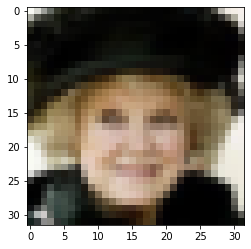

In [42]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [43]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 56.63%


### Visualization

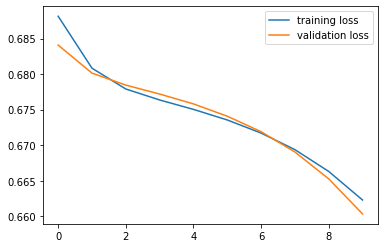

In [44]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

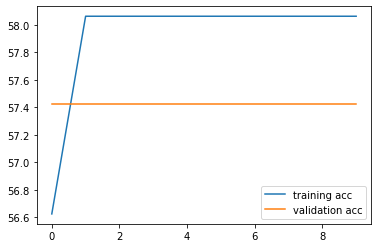

In [45]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## MLP with 20 epochs

In [115]:
model = mlp.MLP()                 # For MLP
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [116]:
## MLP with 20 epochs
base_model_function(model, optimizer, 20)

Epoch: 001/020 | Batch 0000/0636 | Cost: 0.6876
Epoch: 001/020 | Batch 0050/0636 | Cost: 0.6872
Epoch: 001/020 | Batch 0100/0636 | Cost: 0.6843
Epoch: 001/020 | Batch 0150/0636 | Cost: 0.6851
Epoch: 001/020 | Batch 0200/0636 | Cost: 0.6827
Epoch: 001/020 | Batch 0250/0636 | Cost: 0.6789
Epoch: 001/020 | Batch 0300/0636 | Cost: 0.6865
Epoch: 001/020 | Batch 0350/0636 | Cost: 0.6868
Epoch: 001/020 | Batch 0400/0636 | Cost: 0.6851
Epoch: 001/020 | Batch 0450/0636 | Cost: 0.6876
Epoch: 001/020 | Batch 0500/0636 | Cost: 0.6830
Epoch: 001/020 | Batch 0550/0636 | Cost: 0.6778
Epoch: 001/020 | Batch 0600/0636 | Cost: 0.6739
Epoch: 001/020 | Train: 58.063% | Valid: 57.427%
Time elapsed: 0.54 min
Epoch: 002/020 | Batch 0000/0636 | Cost: 0.6853
Epoch: 002/020 | Batch 0050/0636 | Cost: 0.6851
Epoch: 002/020 | Batch 0100/0636 | Cost: 0.6802
Epoch: 002/020 | Batch 0150/0636 | Cost: 0.6799
Epoch: 002/020 | Batch 0200/0636 | Cost: 0.6800
Epoch: 002/020 | Batch 0250/0636 | Cost: 0.6810
Epoch: 002/020 |

### Visualization

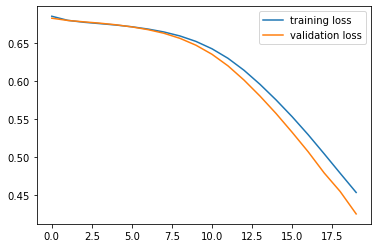

In [117]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

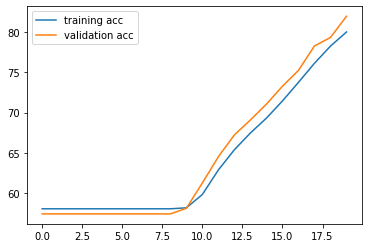

In [118]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## MLP with larger learning rate (0.001 -> 0.1)

In [119]:
model = mlp.MLP()                 # For MLP
model = model.to(device)

## bigger learning rate 0.001 -> 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [120]:
## bigger learning rate 0.001 -> 0.01
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.6911
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.6844
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.6738
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.7032
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.6675
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.6684
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.6684
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.6819
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.6662
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.6720
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.6800
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.6542
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.6590
Epoch: 001/010 | Train: 58.063% | Valid: 57.427%
Time elapsed: 0.55 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.6426
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.6743
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.6717
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.6434
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.6383
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.6293
Epoch: 002/010 |

### Visualization

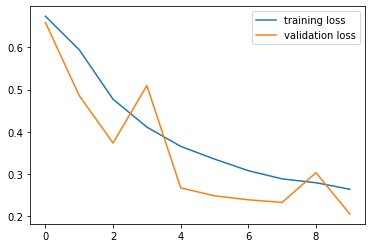

In [121]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

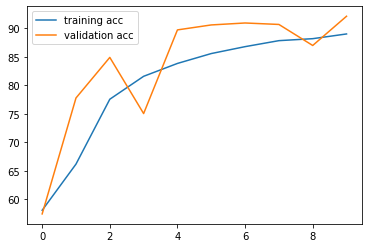

In [122]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## VGG

In [109]:
model = vgg.VGG11()               
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [92]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [93]:
# model - VGG11
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.7362
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.4991
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.4744
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.3561
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.4083
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.3173
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.2793
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.2758
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.3186
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.2163
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.2262
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.2264
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.2062
Epoch: 001/010 | Train: 85.918% | Valid: 92.012%
Time elapsed: 0.39 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.2692
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.1813
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.2145
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.1375
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.1756
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.2085
Epoch: 002/010 |

### Evaluation

In [94]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 94.68%


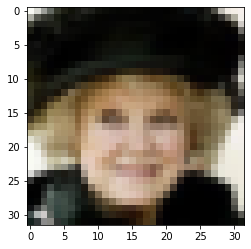

In [95]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [96]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 100.00%


### Visualization

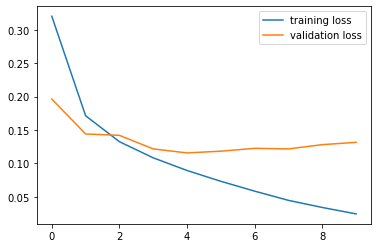

In [97]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [98]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

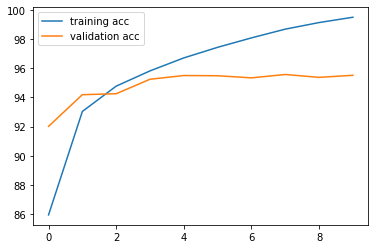

In [99]:
plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## ResNet

### ResNet Basic

In [100]:
model = resnet.ResNet18()               
model = model.to(device)

In [101]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [102]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [103]:
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.7165
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.6454
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.6016
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.5727
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.5455
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.4994
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.4864
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.4613
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.3579
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.3767
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.3256
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.3052
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.2757
Epoch: 001/010 | Train: 78.140% | Valid: 90.592%
Time elapsed: 2.12 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.2200
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.2050
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.2005
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.2515
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.1510
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.1651
Epoch: 002/010 |

### Evaluation

In [104]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 94.64%


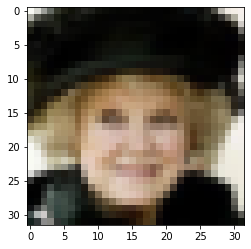

In [105]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [106]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 92.90%


### Visualization

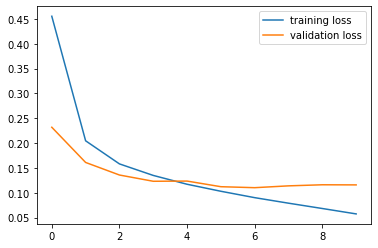

In [107]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

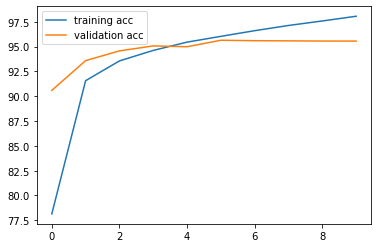

In [108]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()